In [1]:
import os
import sys
sys.path.append("..")

In [2]:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "1" # "1", "2", "3"

# IPL-VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

In [3]:
import jax
import optax
import distrax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable
from torchvision.datasets import FashionMNIST

import vae
import ipl_vae as linvae

In [4]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [5]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [ ]:
root = "/tmp/fashion-mnist"
mnist_train = FashionMNIST(root, download=True, train=True)
mnist_test = FashionMNIST(root, download=True, train=False)

In [7]:
key = jax.random.PRNGKey(314)
key_fa_param, key_sample, key = jax.random.split(key, 3)
key_vae, key_iplvae = jax.random.split(key)

In [8]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

## IPL - VAE

In [9]:
key_ipl, key_init_params = jax.random.split(key_iplvae, 2)

In [10]:
class FADecoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a Factor Analysis (FA) model
    """
    dim_obs: int
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()
    uniform_init: Callable = nn.initializers.uniform()

    
    def setup(self):
        self.b = self.param("b", self.normal_init, (self.dim_obs,))
        self.A = self.param("A", self.normal_init, (self.dim_obs, self.dim_latent))
        # self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs, self.dim_latent))
        self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs,))


    def eval_mean(self, z):
        mean_x = jnp.einsum("...m,dm->...d", z, self.A)+ self.b
        return mean_x
    
    def eval_diag_cov(self, z):
        # logvar_x = jnp.einsum("...m,dm->...d", z, self.logPsi)
        zeros = jnp.zeros((self.dim_obs, self.dim_latent))
        logvar_x = jnp.einsum("...m,dm->...d", z, zeros) + self.logPsi

        return logvar_x


    def __call__(self, z):
        mean_x = self.eval_mean(z)
        logvar_x = self.eval_diag_cov(z)
        
        return mean_x, logvar_x

    
class Decoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a 
    """
    dim_obs: int
    dim_latent: int = 20
    normal_init: Callable = nn.initializers.normal()
    
    def setup(self):
        self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs,))
    
    def eval_diag_cov(self, z):
        # logvar_x = jnp.einsum("...m,dm->...d", z, self.logPsi)
        zeros = jnp.zeros((self.dim_obs, self.dim_latent))
        logvar_x = jnp.einsum("...m,dm->...d", z, zeros) + self.logPsi

        return logvar_x

    @nn.compact
    def __call__(self, z):
        x = nn.Dense(30)(z)
        x = nn.relu(x)
        mean_x = nn.Dense(self.dim_obs, use_bias=True)(x)
        # logvar_x = nn.Dense(self.dim_obs, use_bias=False)(x)
        logvar_x = self.eval_diag_cov(z)
        
        return mean_x, logvar_x


class HomkDecoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a homoskedastic generative process
    """
    dim_obs: int
    dim_latent: int = 20
    normal_init: Callable = nn.initializers.normal()
    
    def setup(self):
        self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs,))
    
    def eval_diag_cov(self, z):
        # logvar_x = jnp.einsum("...m,dm->...d", z, self.logPsi)
        zeros = jnp.zeros((self.dim_obs, self.dim_latent))
        logvar_x = jnp.einsum("...m,dm->...d", z, zeros) + self.logPsi

        return logvar_x


    @nn.compact
    def __call__(self, z):
        x = nn.Dense(30)(z)
        x = nn.relu(x)
        mean_x = nn.Dense(self.dim_obs, use_bias=True)(x)
        # logvar_x = nn.Dense(self.dim_obs, use_bias=False)(x)
        logvar_x = self.eval_diag_cov(z)
        
        return mean_x, logvar_x


## Run process

In [11]:
def loss_nmll(params, z_batch, X_batch, model):
    """
    Loss function
    -------------
    
    Negative Marginal log-likelihood for hard EM
    """
    batch_size = len(X_batch)
    dim_latent = model.dim_latent
    # keys = jax.random.split(key, batch_size)
    
    mean_x, logvar_x = model.apply(params, z_batch)
    std_x = jnp.exp(logvar_x / 2)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.MultivariateNormalDiag(mean_x, std_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch)
    
    log_prob = log_prob_z_prior + log_prob_x
    
    return -log_prob.sum()

In [12]:
dim_latent = 50

In [14]:
def epoch_step(params_decoder, z_est, states, tx, n_its=1):
    opt_latent_state, opt_params_state = states
    # E-step
    for i in range(n_its):
        grad_z = jax.grad(loss_nmll, 1)(params_decoder, z_est, X_train, decoder)
        # z_est = z_est - learning_rate * grad_z
        updates, opt_latent_state = tx.update(grad_z, opt_latent_state, z_est)
        z_est = optax.apply_updates(z_est, updates)
    
    for i in range(n_its):
        # M-step
        nll, grad_theta = jax.value_and_grad(loss_nmll, 0)(params_decoder, z_est, X_train, decoder)
        # params_decoder = jax.tree_map(lambda x, dx: x - learning_rate * dx, params_decoder, grad_theta)
        updates, opt_params_state = tx.update(grad_theta, opt_params_state, params_decoder)
        params_decoder = optax.apply_updates(params_decoder, updates)
    
    return nll, params_decoder, z_est

# states = (opt_latent_state, opt_params_state)
#epoch_step = jax.jit(partial(epoch_step, states=states, tx=tx, n_its=10))

In [63]:
batch_init = jnp.ones((1, dim_latent))
decoder = HomkDecoder(dim_obs, dim_latent)

params_decoder = decoder.init(key_init_params, batch_init)
z_est = jax.random.normal(key, (n_train, dim_latent))

learning_rate = 1e-3
tx = optax.adam(learning_rate)
    
opt_params_state = tx.init(params_decoder)
opt_latent_state = tx.init(z_est)

In [64]:
states = (opt_latent_state, opt_params_state)

n_epochs = 2000
list_n_its = [1, 2, 5, 10, 15, 50]
dict_mll = {}
for n_its in list_n_its:
    nll_hist = []
    
    params_decoder = decoder.init(key_init_params, batch_init)
    z_est = jax.random.normal(key, (n_train, dim_latent))
    part_step = jax.jit(partial(epoch_step, states=states, tx=tx, n_its=n_its))
    for i in tqdm(range(n_epochs)):
        nll, params_decoder, z_est = part_step(params_decoder, z_est)
        nll_hist.append(nll)
        print(f"{nll:0.4e}", end="\r")
    dict_mll[n_its] = nll_hist

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

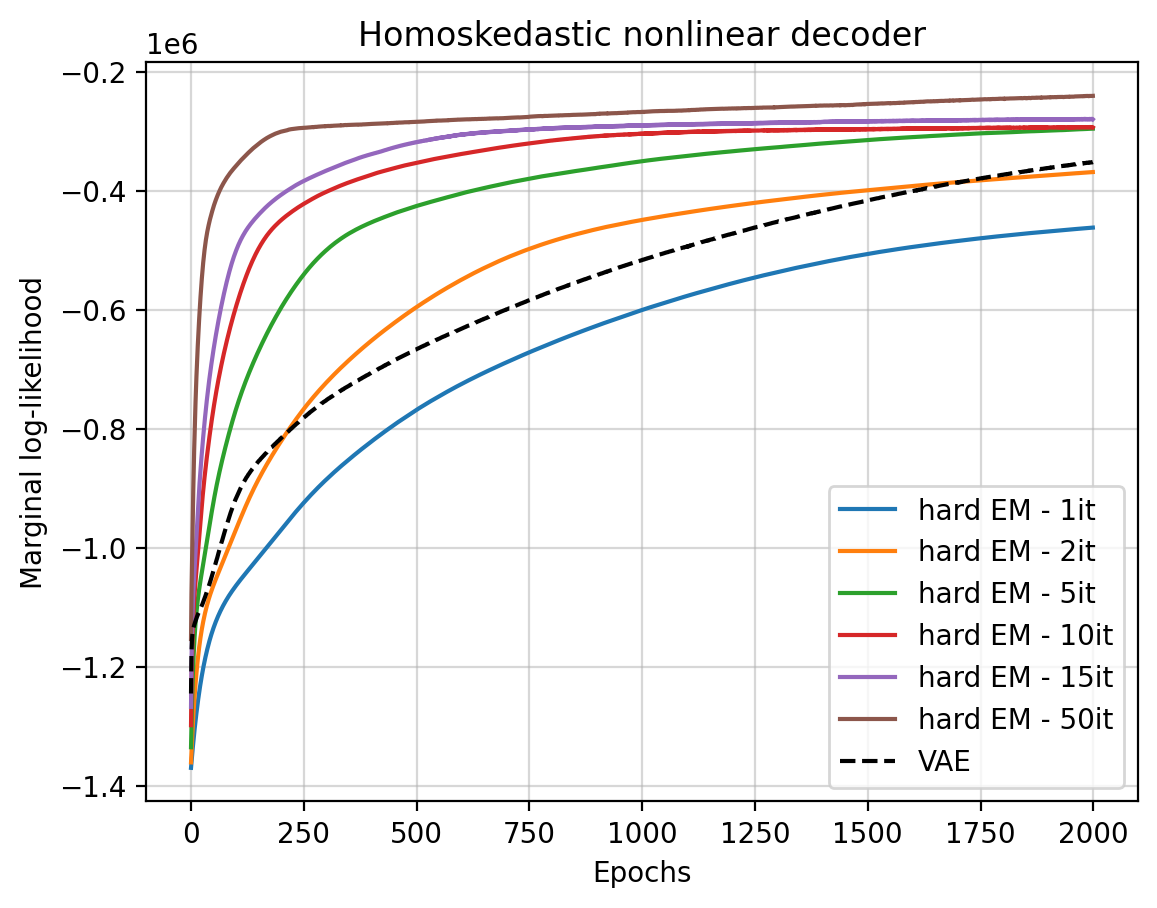

In [65]:
for n_it, nll_hist in dict_mll.items():
    ll_hist = -jnp.array(nll_hist)
    
    plt.plot(ll_hist, label=f"hard EM - {n_it}it")
plt.plot(hist_mll_vae, label="VAE", c="black", linestyle="--")
plt.title("Homoskedastic nonlinear decoder")
plt.ylabel("Marginal log-likelihood")
plt.xlabel("Epochs")
plt.legend()
plt.grid(alpha=0.5)

## Analysing posterior observations

In [56]:
n_samples = 7
key_choice, keys_is = jax.random.split(key_vae)
keys_is = jax.random.split(keys_is, n_samples)

In [57]:
ixs_test

DeviceArray([180, 609, 761, 555, 119, 599, 219], dtype=int32)

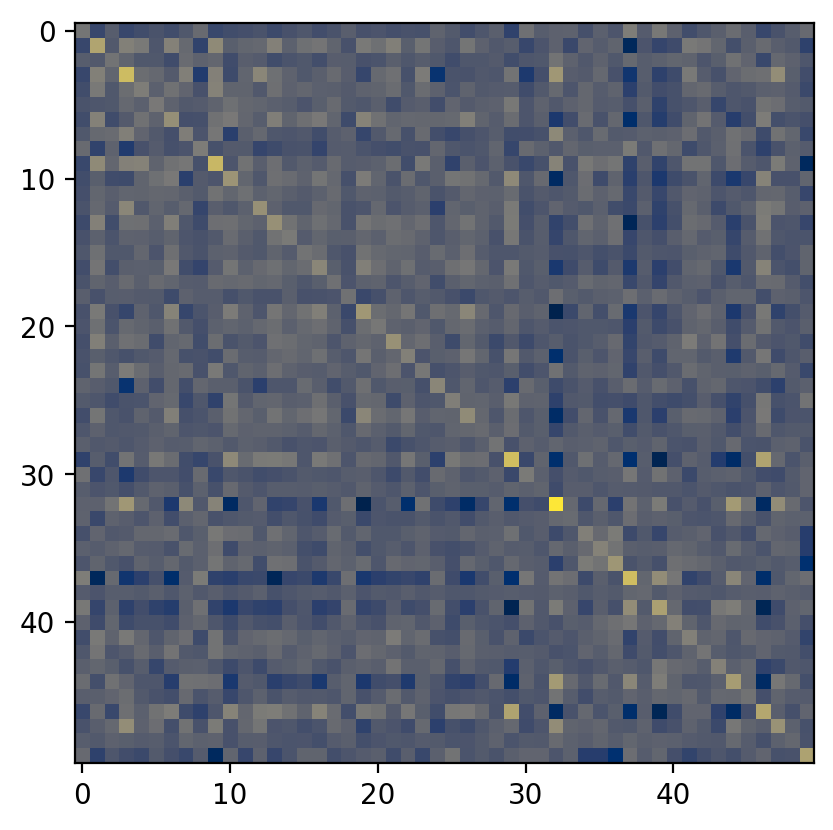

In [58]:
plt.imshow(jnp.cov(z_est.T), cmap="cividis")

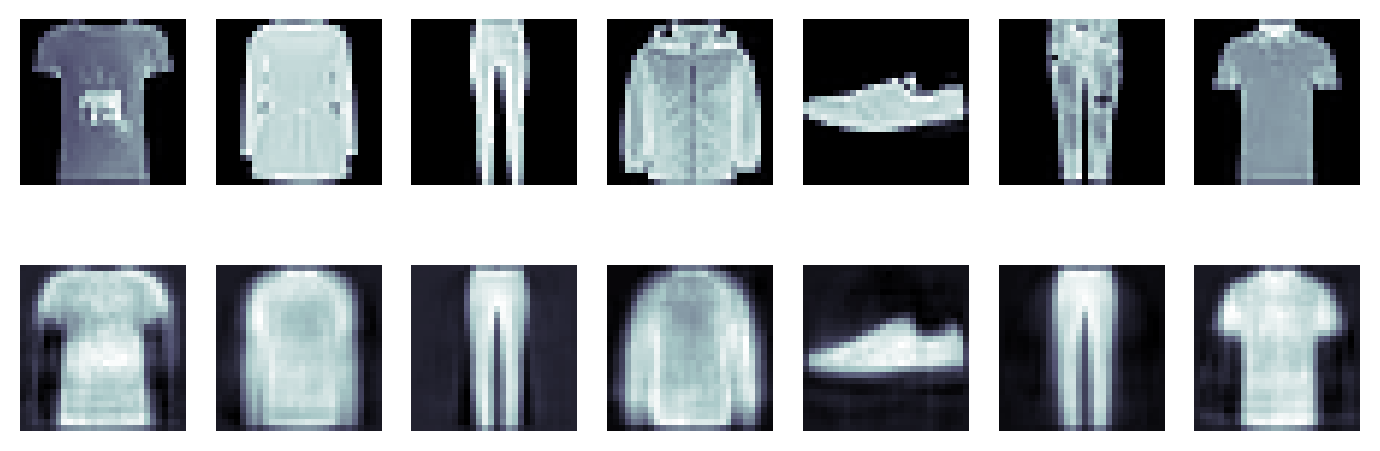

In [59]:
ixs_test = jax.random.choice(key_choice, len(X_train), (n_samples,))
fig, ax = plt.subplots(2, n_samples, figsize=(7, 3.0))


cmap = "bone"
mean_x, var_x = decoder.apply(params_decoder, z_est)
for ax, ix, key in zip(ax.T, ixs_test, keys_is):
    obs = X_train[ix]

    ax[0].imshow(obs.reshape(28, 28), cmap=cmap)
    ax[1].imshow(mean_x[ix].reshape(28, 28), cmap=cmap)
    ax[0].axis("off")
    ax[1].axis("off")
plt.tight_layout()